# Superhero (and Supervillain) Name Generator

---

[Superhero Names Dataset](https://github.com/am1tyadav/superhero)

## Task 2

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [ ]:
!git clone https://github.com/am1tyadav/superhero.git

In [2]:
with open('superhero/superheroes.txt','r') as f:
  data =f.read()
data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [5]:
tokenizer.fit_on_texts(data)

In [6]:
char_to_index = tokenizer.word_index
index_to_char = dict((v,k) for k,v in char_to_index.items())
print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


## Task 3

1. Converting between names and sequences

In [7]:
names = data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [8]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [9]:
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [10]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [11]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i!=0])

In [12]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

## Task 4

1. Creating sequences
2. Padding all sequences

In [13]:
sequences = []
for name in names:
  seq = name_to_seq(name)
  if len(seq)>=2:
    sequences+=[seq[:i] for i in range(2,len(seq)+1) ]

In [14]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [15]:
max_len = max([len(x) for x in sequences])
print(max_len)

33


In [16]:
padded_sequences  = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,padding='pre',
    maxlen=max_len

)

print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [17]:
padded_sequences.shape

(88279, 33)

## Task 5: Creating Training and Validation Sets

1. Creating training and validation sets

In [18]:
x, y = padded_sequences[:,:-1], padded_sequences[:,-1]
print(x.shape,y.shape)

(88279, 32) (88279,)


In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [20]:
num_chars = len(char_to_index.keys())+1
print(num_chars)

29


## Task 6: Creating the Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Conv1D,MaxPool1D,LSTM,Bidirectional,Dense

model = Sequential([
                    Embedding(num_chars,8,input_length=max_len-1),
                    Conv1D(64,5,strides=1,activation='tanh',padding='causal'),
                    MaxPool1D(2),
                    LSTM(32),
                    Dense(num_chars,activation="softmax")
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 8)             232       
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 29)                957       
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
_________________________________________________________________


## Task 7: Training the Model

In [22]:
h = model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=50,verbose=2,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
    ]
)

Epoch 1/50
2070/2070 - 14s - loss: 2.7371 - accuracy: 0.1927 - val_loss: 2.5819 - val_accuracy: 0.2287
Epoch 2/50
2070/2070 - 14s - loss: 2.5303 - accuracy: 0.2382 - val_loss: 2.4939 - val_accuracy: 0.2563
Epoch 3/50
2070/2070 - 14s - loss: 2.4614 - accuracy: 0.2593 - val_loss: 2.4443 - val_accuracy: 0.2619
Epoch 4/50
2070/2070 - 14s - loss: 2.4133 - accuracy: 0.2702 - val_loss: 2.4091 - val_accuracy: 0.2744
Epoch 5/50
2070/2070 - 14s - loss: 2.3760 - accuracy: 0.2796 - val_loss: 2.3783 - val_accuracy: 0.2829
Epoch 6/50
2070/2070 - 13s - loss: 2.3415 - accuracy: 0.2902 - val_loss: 2.3560 - val_accuracy: 0.2886
Epoch 7/50
2070/2070 - 15s - loss: 2.3115 - accuracy: 0.3023 - val_loss: 2.3329 - val_accuracy: 0.2978
Epoch 8/50
2070/2070 - 15s - loss: 2.2829 - accuracy: 0.3101 - val_loss: 2.3142 - val_accuracy: 0.2992
Epoch 9/50
2070/2070 - 15s - loss: 2.2565 - accuracy: 0.3195 - val_loss: 2.3008 - val_accuracy: 0.3105
Epoch 10/50
2070/2070 - 15s - loss: 2.2330 - accuracy: 0.3260 - val_loss:

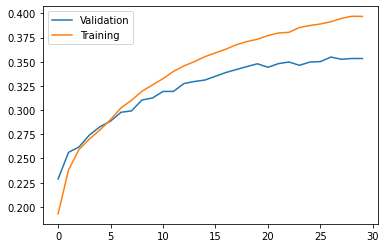

In [23]:
from matplotlib import pyplot as plt
epochs_ran = len(h.history['loss'])

plt.plot(range(0,epochs_ran),h.history['val_accuracy'],label='Validation')
plt.plot(range(0,epochs_ran),h.history['accuracy'],label='Training')
plt.legend()
plt.show()


## Task 8: Generate Names!

In [24]:
def generate_names(seed):
  for i in range(0,40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq],padding='pre',
                                                           maxlen=max_len-1,
                                                           truncating='pre')
    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char == '\t':
      break

  print(seed)

In [33]:
generate_names('w')

warlen scarketer	
